# **ELEMENTOS FINITOS OLVER**

## **Ejemplo 14.9**

Let us describe how to set up the finite element approximation to such a boundary
value problem. We begin with a very coarse triangulation of the plate, which will not give
particularly accurate results, but does serve to illustrate how to go about assembling the
finite element matrix. We divide the rectangular part of the plate into 8 right triangles,
while each semicircular end will be approximated by three equilateral triangles. The triangles are numbered from 1 to 14 as indicated in Figure 14.12. There are 13 nodes in all,
numbered as in the second figure. 

In [ ]:
import sys
!{sys.executable} -m pip install --user numpy
!{sys.executable} -m pip install --user matplotlib

import matplotlib.pyplot as plt 
import numpy as np

np.set_printoptions(suppress=True)

Dibujamos el plato ovalado con las especificaciones del enunciado junto con la triangulación propuesta. 

In [ ]:


def oval_plate():
    point1 = [0.5, 0]
    point2 = [2.5, 0]

    point3 = [0.5, 1]
    point4 = [2.5, 1]

    x_values1 = [point1[0], point2[0]]
    y_values1 = [point1[1], point2[1]]

    x_values2 = [point3[0], point4[0]]
    y_values2 = [point3[1], point4[1]]


    plt.plot(x_values1, y_values1, color="black")
    plt.plot(x_values2, y_values2, color="black")
    plt.axis('off')
    plt.show()



    
    return None

oval_plate()

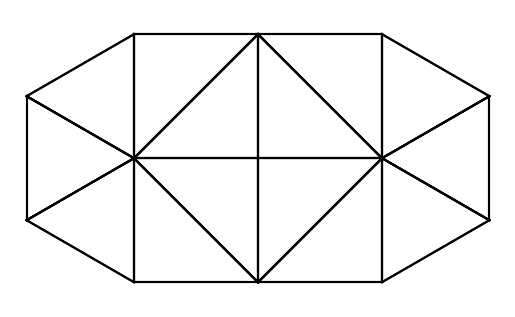

In [98]:
def pointsCoordenates():
    points = []
    triangles = []

    point1 = [0, 0.5]
    point2 = [0.5, 0.5]
    point3 = [1.0, 0.5]
    point4 = [0.5, 1.0]
    point5 = [0, 1.0]
    point6 = [(-(0.25*np.sqrt(3))), 0.75]
    point7 = [(-(0.25*np.sqrt(3))), 0.25]
    point8 = [0, 0]
    point9 = [0.5, 0]
    point10 = [1.0, 0]
    point11 = [1.0 + (0.25*np.sqrt(3)), 0.25]
    point12 = [1.0 + (0.25*np.sqrt(3)), 0.75]
    point13 = [1.0, 1.0]

    triangle1 = [1,5,6]
    triangle2 = [1,6,7]
    triangle3 = [1,7,8]
    triangle4 = [1,5,4]
    triangle5 = [1,2,4]
    triangle6 = [2,3,4]
    triangle7 = [3,4,13]
    triangle8 = [1,8,9]
    triangle9 = [1,2,9]
    triangle10 = [2,3,9]
    triangle11 = [3,9,10]
    triangle12 = [3,12,13]
    triangle13 = [3,11,12]
    triangle14 = [3,11,10]

    for i in range(1,14):
         points.append(eval("point" + str(i)))
    
    for i in range(1,15):
         triangles.append(eval("triangle" + str(i)))

    return points, triangles
    
def graphPoints(points, triangles):
     for triangle in triangles:
          for point1 in triangle:
               for point2 in triangle:
                    coordpoint1 = points[point1 - 1]
                    coordpoint2 = points[point2 - 1]

                    x_values = [coordpoint1[0], coordpoint2[0]]
                    y_values = [coordpoint1[1], coordpoint2[1]]

                    plt.plot(x_values, y_values, color="black")



     plt.xlim(-0.5, 1.5)
     plt.ylim(-0.1, 1.1)
     plt.gca().set_aspect('equal', adjustable='box')
     plt.axis('off')
     plt.show()

     return None

points = pointsCoordenates()[0]
triangles = pointsCoordenates()[1]

graphPoints(points, triangles)

                    

In [ ]:
points = pointsCoordenates()[0]
triangles = pointsCoordenates()[1]

def getAngles(points, triangles):
    triangle_angles = []
    for triangle in triangles:
        angles = []
        for i, point_index in enumerate(triangle):
            point = points[point_index - 1]
            if i == 0:
                pointa = points[triangle[1]-1]
                pointc = points[triangle[2]-1]
            
            if i == 1:
                pointa = points[triangle[0]-1]
                pointc = points[triangle[2]-1]

            if i == 2:
                pointa = points[triangle[0]-1]
                pointc = points[triangle[1]-1]

            a = np.array(pointa)
            b = np.array(point)
            c = np.array(pointc)

            ba = a - b
            bc = c - b

            cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))

            angle = np.arccos(cosine_angle)
            angle = round(np.degrees(angle))
            

            angles.append(angle)

        triangle_angles.append(angles)
    
    return triangle_angles

angles = getAngles(points, triangles)

def KMatrix(points, triangles, angles):
    index = [0,1,2]
    K_matrix = np.zeros((len(points), len(points)))

    for v, triangle in enumerate(triangles):
        K_triangle = np.zeros((len(points), len(points)))

        for i, point_index_i in enumerate(triangle):
            for j, point_index_j in enumerate(triangle): 
                if i == j:
                    if i == 0:
                        angle_1 = 1/np.tan(np.radians(angles[v][1])) 
                        angle_2 = 1/np.tan(np.radians(angles[v][2])) 
                        k_entry = 0.5*(angle_1 + angle_2)
                    if i == 1:
                        angle_1 = 1/np.tan(np.radians(angles[v][0])) 
                        angle_2 = 1/np.tan(np.radians(angles[v][2])) 
                        k_entry = 0.5*(angle_1 + angle_2)
                    if i == 2:
                        angle_1 = 1/np.tan(np.radians(angles[v][1])) 
                        angle_2 = 1/np.tan(np.radians(angles[v][0])) 
                        k_entry = 0.5*(angle_1 + angle_2)
                else:
                    for m in index:
                        if (m != i) and (m != j) :
                            angle_1 = 1/np.tan(np.radians(angles[v][m]))  
                            k_entry = -0.5*(angle_1)
                
                K_triangle[point_index_i-1,point_index_j-1] = k_entry
            
        K_matrix += K_triangle
    
    return K_matrix  